# Libraries

In [1]:
## Useful libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
import copy
import pickle
from urllib.request import urlretrieve
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import TwoSlopeNorm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Additional input
import networkx as nx
from tqdm import tqdm
# !pip install torch_geometric
from torch_geometric.data import Data
# !pip install perlin-noise
from perlin_noise import PerlinNoise
import random
from loader import load_dataset
from datetime import datetime

from cycler import cycler
import seaborn as sns
import time

# Set the color scheme
sns.set_theme()
colors = ['#0076C2', '#EC6842', '#A50034', '#009B77', '#FFB81C', '#E03C31', '#6CC24A', '#EF60A3', '#0C2340', '#00B8C8', '#6F1D77']
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from functions import *

# Dataset
The data folder comprises 4 subfolders (DEM, WD, VX, VY), containing the elevation, water depths in time, and velocities (in x and y directions) in time for all training and testing simulations. The overview.csv file provides the runtime of the numerical model on each different simulation, identified by its id.

- 1-80: Training and validation

- 501-520: Testing dataset 1

- 10001-10020: Testing dataset 2

- 15001-15020: Testing dataset 3

In [2]:
data_folder = 'raw_datasets/'

train_dataset = 'DEM/'

In [3]:
dataset_folder = data_folder
n_sim = 80
start_sim = 1
dataset_name = 'grid'

datasets_folder = 'datasets'
if not os.path.exists(datasets_folder):
    os.makedirs(datasets_folder)
    
dataset_dir = datasets_folder + '/train'


##################### Use this code to create local pickle file #####################
# pyg_dataset = create_grid_dataset(dataset_folder, n_sim=n_sim)
# save_database(pyg_dataset, name=dataset_name, out_path=dataset_dir)

train_dataset = load_dataset(dataset_name=dataset_name, dataset_folder=dataset_dir)

## Visualization

Start visualization of the data to get a better understanding

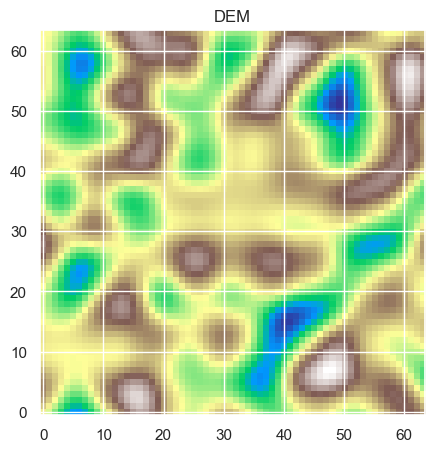

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
number_grids = 64

axs.imshow(train_dataset[0]['DEM'].reshape(number_grids,number_grids), cmap='terrain', origin='lower')
axs.set_title('DEM')

plt.show()
axs.clear()
plt.show()

# Normalization

Since the input and output values may have very different ranges, it is important to perform normalization to both.

In [5]:
def normalize_dataset(dataset, scaler_DEM, scaler_WD):
    
    min_DEM, max_DEM = scaler_DEM.data_min_[0], scaler_DEM.data_max_[0]
    min_WD, max_WD = scaler_WD.data_min_[0], scaler_WD.data_max_[0]
    normalized_dataset = []

    for idx in range(len(dataset)):
        DEM = dataset[idx]['DEM']
        WD = dataset[idx]['WD']
        norm_DEM = (DEM - min_DEM) / (max_DEM - min_DEM)
        norm_WD = (WD - min_WD) / (max_WD - min_WD)

        DEM = norm_DEM.reshape(64,64)
        WD = norm_WD[:,0].reshape(64,64)
        

        DEM = norm_DEM.reshape(64,64)
        WD = norm_WD[:,0].reshape(64,64)
        
        temp_dict = {}
        temp_dict['Input'] = torch.stack((DEM, WD), dim=0)

        WD_transposed = norm_WD[:, 1:].reshape(64,64, -1)
        WD_transposed = WD_transposed.transpose(0, 2)
        WD_transposed = WD_transposed.transpose(1, 2)
        temp_dict['WD'] = WD_transposed
    
        normalized_dataset.append(temp_dict)
    
    return normalized_dataset

In [6]:
# Normalize the inputs and outputs using training dataset
scaler_DEM = MinMaxScaler() # Can store DEM, VX, VY as one 'input' Scaler
scaler_WD = MinMaxScaler()

for index in range(len(train_dataset)): # =80
    scaler_DEM.partial_fit(train_dataset[index]['DEM'].reshape(-1, 1).cpu())
    scaler_WD.partial_fit(train_dataset[index]['WD'].reshape(-1, 1).cpu())

normalized_train_dataset = normalize_dataset(train_dataset, scaler_DEM, scaler_WD)

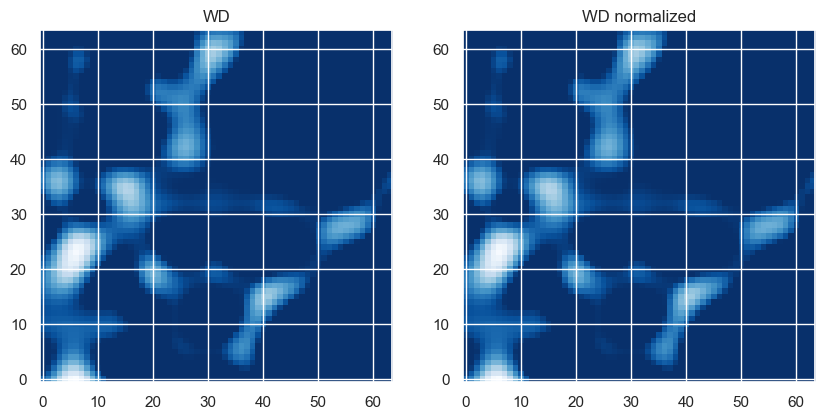

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(train_dataset[0]['WD'][:,-1].reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[0].set_title('WD')

axs[1].imshow(normalized_train_dataset[0]['WD'][-1].reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[1].set_title('WD normalized')
plt.show()

In [8]:
# Split dataset into train, validation, and testing
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
training_dataset, val_dataset = random_split(normalized_train_dataset, [train_size, val_size])

In [9]:
# Dataset has two variables, training data DEM, target WD
print('Amount of variables', len(normalized_train_dataset[0]))
print(f'Size of WD data ({normalized_train_dataset[0]["WD"].shape})')

Amount of variables 2
Size of WD data (torch.Size([96, 64, 64]))


# Model

In [10]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()
        
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias)]
        if batch_norm:
            layers.append(nn.BatchNorm2d(num_features=out_channels))
        layers.append(nn.PReLU())
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias))
                
        self.cnnblock = nn.Sequential(*layers)

    def forward(self, x):
        return self.cnnblock(x)

class Encoder(nn.Module):
    def __init__(self, channels=[32, 64, 128], kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()

        self.enc_blocks = nn.ModuleList([
            CNNBlock(channels[block], channels[block+1], kernel_size, padding, bias, 
                     batch_norm=batch_norm) 
            for block in range(len(channels)-1)]
            )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        print('Encoder forward:', x.shape)
        outs = []
        for block in self.enc_blocks:
            x = block(x)
            outs.append(x)
            x = self.pool(x)
        print('Encoder output:', x.shape)
        return outs

class Decoder(nn.Module):
    def __init__(self, channels=[128, 64, 32], kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(channels[block], channels[block+1], kernel_size=2, padding=0, stride=2) 
            for block in range(len(channels)-1)]
            )
        self.dec_blocks = nn.ModuleList([
            CNNBlock(channels[block], channels[block+1], kernel_size, padding, bias, 
                     batch_norm=batch_norm)
             for block in range(len(channels)-1)]
             )
        
    def forward(self, x, x_skips):
        print('Decoder forward:', x.shape)
        for i in range(len(x_skips)):
            x = self.upconvs[i](x)
            x = torch.cat((x, x_skips[-(1+i)]), dim=1)
            x = self.dec_blocks[i](x)

        x = self.dec_blocks[-1](x)
        print('Decoder output:', x.shape)
        return x
    
class CNN(nn.Module):
    def __init__(self, node_features, out_dim=96, n_downsamples=3, initial_hid_dim=64, batch_norm=True, 
                 bias=True):
        super(CNN, self).__init__()
        hidden_channels = [initial_hid_dim*2**i for i in range(n_downsamples)]
        encoder_channels = [node_features]+hidden_channels
        decoder_channels = list(reversed(hidden_channels))+[out_dim]

        self.encoder = Encoder(encoder_channels, kernel_size=3, padding=1, 
                               bias=bias, batch_norm=batch_norm)
        self.decoder = Decoder(decoder_channels, kernel_size=3, padding=1, 
                               bias=bias, batch_norm=batch_norm)
        
    def forward(self, x):
        print('Forward: x input size', x.shape)
        x = self.encoder(x)
        print(len(x))
        print(x[0].shape)
        x = self.decoder(x[-1], x[:-1])
        print(x.shape)
        x = nn.Sigmoid()(x)
        print('Output shape', x.shape)
        print('')
        return x
    
node_features = 2
model = CNN(node_features=node_features, n_downsamples=4, initial_hid_dim=32, 
            batch_norm=True, bias=True)

In [11]:
def train_epoch(model, loader, optimizer, device='cpu'):
    model.to(device)
    model.train() # specifies that the model is in training mode

    losses = []

    for batch in loader:
        
        x = batch['Input']   # [batch_size, channels, height, width]
        y = batch['WD'] 
        
        # Model prediction
        preds = model(x)
        
        # MSE loss function
        loss = nn.MSELoss()(preds, y)
        
        losses.append(loss.cpu().detach())
        
        # Backpropagate and update weights
        loss.backward()   # compute the gradients using backpropagation
        optimizer.step()  # update the weights with the optimizer
        optimizer.zero_grad(set_to_none=True)   # reset the computed gradients

    losses = np.array(losses).mean()

    return losses

In [12]:
def evaluation(model, loader, device='cpu'):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode
    
    losses = []
    
    with torch.no_grad():
        for batch in loader:
            x = batch['Input']
            y = batch['WD']  # [:,:,:,1]

            # Model prediction
            preds = model(x)

            # MSE loss function
            loss = nn.MSELoss()(preds, y)
            losses.append(loss.cpu().detach())

    losses = np.array(losses).mean()

    return losses

# Define hyperparameters and dataloaders

In [13]:
# Set training parameters
learning_rate = 0.0002
batch_size = 8 ### 1, 2, 4, 5, 8, 10, 16, 20, 40, or 80
num_epochs = 20

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#test_loader = DataLoader(normalized_test_dataset, batch_size=batch_size, shuffle=False)


# Training and validation

In [14]:
#create vectors for the training and validation loss
train_losses = []
val_losses = []
no_improvement = 0

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch(model, train_loader, optimizer, device=device)

    # Model validation
    val_loss = evaluation(model, val_loader, device=device)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        no_improvement = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    no_improvement += 1
    
    if epoch%5 == 0:
        print("epoch:",epoch, "\t training loss:", np.round(train_loss,4),
                            "\t validation loss:", np.round(val_loss,4),
                            "\t best validation loss:", np.round(best_loss,4))     
        
        # Plot prediction for one sample
        data_id = 4
        test_x = normalized_train_dataset[data_id]['Input'].reshape(1, 2, 64, 64)
        test_WD = normalized_train_dataset[data_id]['WD'][-1,:,:]

        # predict the WD
        pred_WD = best_model(test_x).detach()

        pred_last_WD = pred_WD[:,-1,:,:]

        show_WD = test_WD.reshape(64,64)
        show_pred_WD = pred_last_WD.reshape(64,64)
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].imshow(show_WD.reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
        axs[0].set_title('WD target')

        axs[1].imshow(show_pred_WD.reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
        axs[1].set_title('WD prediction')
        plt.show()
    
    if no_improvement >= 20:
        print('No improvement for 20 epochs')
        print('counter', no_improvement)

    
model = copy.deepcopy(best_model)

Forward: x input size torch.Size([8, 2, 64, 64])
Encoder forward: torch.Size([8, 2, 64, 64])
Encoder output: torch.Size([8, 256, 4, 4])
4
torch.Size([8, 32, 64, 64])
Decoder forward: torch.Size([8, 256, 8, 8])
Decoder output: torch.Size([8, 96, 64, 64])
torch.Size([8, 96, 64, 64])
Output shape torch.Size([8, 96, 64, 64])

Forward: x input size torch.Size([8, 2, 64, 64])
Encoder forward: torch.Size([8, 2, 64, 64])
Encoder output: torch.Size([8, 256, 4, 4])
4
torch.Size([8, 32, 64, 64])
Decoder forward: torch.Size([8, 256, 8, 8])
Decoder output: torch.Size([8, 96, 64, 64])
torch.Size([8, 96, 64, 64])
Output shape torch.Size([8, 96, 64, 64])

Forward: x input size torch.Size([8, 2, 64, 64])
Encoder forward: torch.Size([8, 2, 64, 64])
Encoder output: torch.Size([8, 256, 4, 4])
4
torch.Size([8, 32, 64, 64])
Decoder forward: torch.Size([8, 256, 8, 8])
Decoder output: torch.Size([8, 96, 64, 64])
torch.Size([8, 96, 64, 64])
Output shape torch.Size([8, 96, 64, 64])

Forward: x input size torch.

KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.yscale('log')
plt.title('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
# Save model
models_folder = 'models'

if not os.path.exists(models_folder):
    os.makedirs(models_folder)
    
date_time = datetime.now().strftime("%D_%H%M%S")
date_time = date_time.replace('/', '_')
save_path = f'./models/model_{date_time}_lr_{learning_rate}_epochs_{num_epochs}_MSELoss.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
# select one sample
data_id = 70

print(normalized_train_dataset[data_id]['Input'].shape)
print(normalized_train_dataset[data_id]['WD'].shape)

In [ ]:
x = normalized_train_dataset[data_id]['Input'].reshape(1, 2, 64, 64)
WD = normalized_train_dataset[data_id]['WD'][-1,:,:]

# predict the WD
pred_WD = model(x).detach()

# show_x = x.reshape(64,64)
show_WD = WD.reshape(64,64)

pred_last_WD = pred_WD[:,-1,:,:]
show_pred_WD = pred_last_WD.reshape(64,64)

In [ ]:
# Load the best model after training is complete
best_model_path = 'models/model_01_12_24_101357_lr_0.0002_epochs_100_MSELoss.pth'
model.load_state_dict(torch.load(best_model_path))
print("Loaded best model from:", best_model_path)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(show_WD.reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[0].set_title('WD target')

axs[1].imshow(show_pred_WD.reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[1].set_title('WD prediction')
plt.show()

In [ ]:
def update(w, s):
    '''
    Function that creates an interactive plot for the four variables
    w: Timestep
    s: Sample
    
    '''
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].set_title(f'WD target, t={w+1}')
    axs[1].set_title(f'WD prediction t={w+1}')
    
    x = normalized_train_dataset[s]['Input'].reshape(1, 2, 64, 64)
    WD = normalized_train_dataset[s]['WD'][w,:,:]

    # predict the WD
    pred_WD = model(x).detach()

    # show_x = x.reshape(64,64)
    show_WD = WD.reshape(64,64)

    pred_last_WD = pred_WD[:,w,:,:]
    show_pred_WD = pred_last_WD.reshape(64,64)

    axs[0].imshow(show_WD, cmap='Blues_r', origin='lower')
    axs[1].imshow(show_pred_WD, cmap='Blues_r', origin='lower')
    plt.show()
#     fig.canvas.draw_idle()

interact(update, w=widgets.IntSlider(min=0, max=95, step=1, value=0), s=np.arange(0, n_sim-1));

In [ ]:
def update(w, s):
    '''
    Function that creates an interactive plot for the four variables
    w: Timestep
    s: Sample
    
    '''
    fig, axs = plt.subplots(1, 4, figsize=(17,5))
    

    
    x = normalized_train_dataset[s]['Input'].reshape(1, 2, 64, 64)
    WD = normalized_train_dataset[s]['WD'][w,:,:]

    DEM = x[:,0]
    
    # predict the WD
    pred_WD = model(x).detach()

    # show_x = x.reshape(64,64)
    WD = WD.reshape(64,64)

    pred_last_WD = pred_WD[:,w,:,:]
    show_pred_WD = pred_last_WD.reshape(64,64)

    diff_FAT = WD - show_pred_WD
    max_FAT = max(show_pred_WD.max(), WD.max())
    max_diff = max(diff_FAT.max(), -diff_FAT.min())

    axs[0].imshow(DEM.squeeze(), cmap='terrain', origin='lower')
    axs[1].imshow(WD, vmin = 0, vmax=max_FAT, cmap='Blues_r', origin='lower')
    axs[2].imshow(show_pred_WD, vmin = 0, vmax=max_FAT, cmap='Blues_r', origin='lower')
    axs[3].imshow(diff_FAT, vmin =-max_diff, vmax=max_diff, cmap='RdBu', origin='lower')
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = DEM.min(), vmax=DEM.max()),
                                cmap='terrain'), fraction=0.05, shrink=0.9, ax=axs[0])
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_FAT),
                                cmap='Blues_r'), fraction=0.05, shrink=0.9, ax=axs[1])
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_FAT),
                                cmap='Blues_r'), fraction=0.05, shrink=0.9, ax=axs[2])
    plt.colorbar(plt.cm.ScalarMappable(norm=TwoSlopeNorm(vmin=-max_diff, vmax=max_diff, vcenter=0),
                                cmap='RdBu'), fraction=0.05, shrink=0.9, ax=axs[3])
    
    for ax in axs:
        ax.axis('off')

    axs[0].set_title('DEM')
    axs[1].set_title(f'WD target, t={w+1}')
    axs[2].set_title(f'WD prediction t={w+1}')
    axs[3].set_title(f'WD difference, t={w+1}')
    plt.tight_layout()
    plt.show()

interact(update, w=widgets.IntSlider(min=0, max=95, step=1, value=0), s=np.arange(0, n_sim-1));